<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/NeuralNetworks/MNIST_example_NeuralNets_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax.numpy as jnp
import jax
import time

#Load MNIST Dataset

In [ ]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [ ]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())

batch_size = 128
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



## Train and test sets

In [ ]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = np.array(mnist_dataset.train_labels)

N_train = 10000
train_images = train_images[0:N_train,:] #get a subset of the data
train_labels = train_labels[0:N_train]


# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = np.array(mnist_dataset_test.test_labels)


N_test = 10000
test_images = test_images[0:N_test,:] #get a subset of the data
test_labels = test_labels[0:N_test]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Plotting examples of MNIST dataset

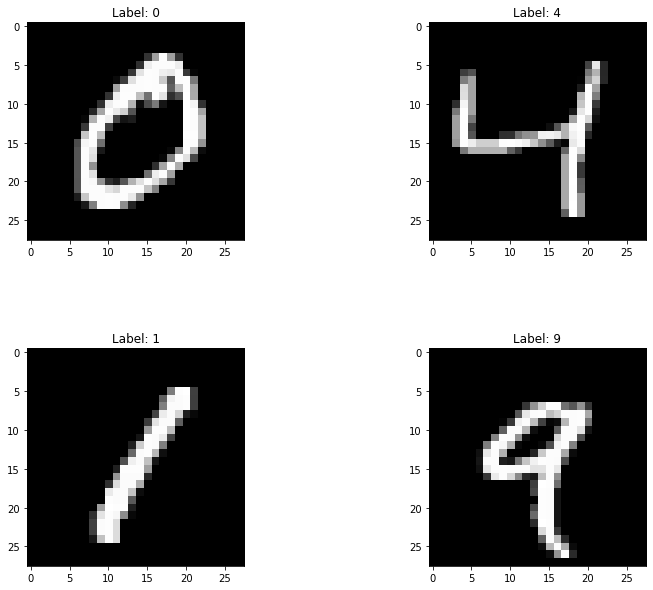

In [ ]:
import matplotlib.pyplot as plt

def plot_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 10))

  #plotting images from the training set
  for i in range(1, n_grid**2 + 1):
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    plt.title(f"Label: {my_labels[i]}")

    img = train_images[i].reshape((28,28))
    plt.imshow(img, cmap='gray')

plot_MNIST_train_examples(train_labels)

# Linear Regression (LinR)

We think of linear regression as a [784 by 1] graph.

## Generate random starting paramaters

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = jax.random.split(key)
  return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = jax.random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

key = jax.random.PRNGKey(int(time.time()))

In [ ]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

## Create our function and our loss function

In [ ]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

def LinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]
  return (jnp.dot(w, x) + b)[0]

print("Lin Reg on 1st training example:")
print(LinR(params,train_images[0]))

Lin Reg on 1st training example:
27.67817


In [ ]:
batched_LinR = jax.vmap(LinR, in_axes=(None, 0))

print("Lin Reg on all training example:")
print(batched_LinR(params,train_images))

Lin Reg on all training example:
[27.67817   71.778244  22.497742  ...  1.1367296  3.9307826 -6.32494  ]


In [ ]:
def MSE_loss_for_LinR(params,images,target):
  preds = batched_LinR(params, images)
  return jnp.mean( (preds - target)**2 )

print("MSE loss of LinR on training set:")
print(MSE_loss_for_LinR(params,train_images,train_labels))

MSE loss of LinR on training set:
562.0832


# Training loop using gradient descent

In [ ]:
import time
from functools import partial

@partial(jax.jit, static_argnames=['loss_func','step_size'])
def update_params(params, x, y, loss_func, step_size):
  grads = jax.grad(loss_func)(params, x, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]


#trains ``params'' according to the given loss_func
def training_loop(loss_func, acc_func=None, num_epochs = 2, step_size = 0.01):
  global params
  saved_results = []
  for epoch in range(1,num_epochs+1):

      #Update the weights by gradient descent!
      start_time = time.time()
      for x, y in training_generator:
          #turn the labels into one hot vectors
          #grads = jax.grad(loss_func)(params, x, y)

          #params = [(w - step_size * dw, b - step_size * db)
                    #for (w, b), (dw, db) in zip(params, grads)]
        params = update_params(params,x,y,loss_func,step_size)

      #### A bunch of bookeeping here.... ####
      #Print and record stats of this epoch
      if acc_func != None:
        train_acc = acc_func(params, train_images, train_labels)
        test_acc = acc_func(params, test_images, test_labels)

      train_CE_loss = loss_func(params, train_images, train_labels)
      test_CE_loss = loss_func(params, test_images, test_labels)

      results_dict = {'epoch': epoch,
              'train_loss': np.copy(train_CE_loss).item(),
              'test_loss': np.copy(test_CE_loss).item(),
              }

      if acc_func != None:
        results_dict['train_acc'] = np.copy(train_acc).item()
        results_dict['test_acc'] = np.copy(test_acc).item()

      saved_results += [results_dict]

      epoch_time = time.time() - start_time
      print(f"---Epoch {epoch} in {epoch_time:0.2f} sec---")
      if acc_func != None:
        print(f"  Train  acc: {train_acc:0.4f}")
        print(f"  Test   acc: {test_acc:0.4f}")
      print(f"  Train loss: {train_CE_loss:0.4f}")
      print(f"  Test  loss: {test_CE_loss:0.4f}")


  return saved_results

In [ ]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)
training_loop(MSE_loss_for_LinR,num_epochs=5,step_size = 0.00000001)

---Epoch 1 in 4.92 sec---
  Train loss: 125.2300
  Test  loss: 121.6224
---Epoch 2 in 2.24 sec---
  Train loss: 88.4078
  Test  loss: 84.7518
---Epoch 3 in 3.05 sec---
  Train loss: 70.7834
  Test  loss: 67.5892
---Epoch 4 in 2.27 sec---
  Train loss: 59.9896
  Test  loss: 57.1951
---Epoch 5 in 2.23 sec---
  Train loss: 52.6544
  Test  loss: 50.1609


[{'epoch': 1,
  'train_loss': 125.23003387451172,
  'test_loss': 121.62239837646484},
 {'epoch': 2, 'train_loss': 88.40776824951172, 'test_loss': 84.75184631347656},
 {'epoch': 3, 'train_loss': 70.783447265625, 'test_loss': 67.58919525146484},
 {'epoch': 4, 'train_loss': 59.98961639404297, 'test_loss': 57.19512939453125},
 {'epoch': 5,
  'train_loss': 52.654422760009766,
  'test_loss': 50.160945892333984}]

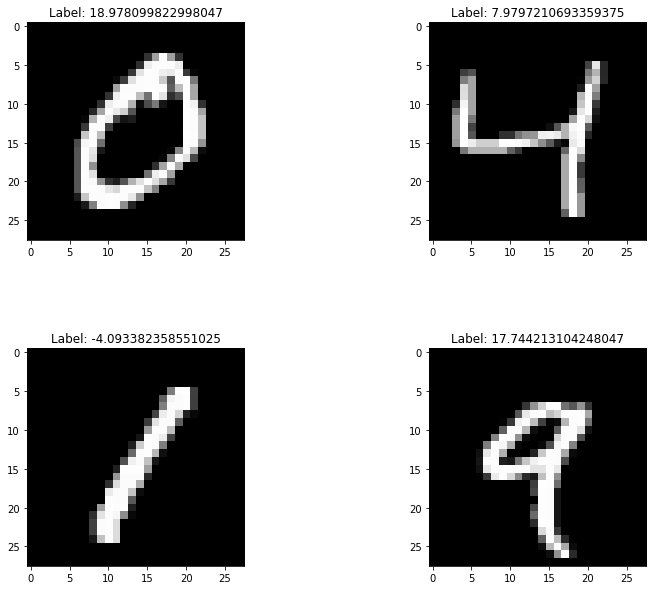

In [ ]:
LinR_labels = batched_LinR(params, train_images)
plot_MNIST_train_examples(LinR_labels)

# Linear Autoencoder


In [ ]:
layer_sizes = [784, 2, 784]
params = init_network_params(layer_sizes, key)

# rectified linear unit activation function
def relu(x):
  return jnp.maximum(0, x) # compute the element-wise function

def LinAE(params, image, low_dim_rep = False):
    # per-example predictions
    x = image
    # first layer is feedforward
    w, b = params[0]
    x = (jnp.dot(w, x) + b)
    x_relu = x #relu(x)

    low_dim_layer = 1
    for w, b in params[1:low_dim_layer]:
        #skip pre activations
        x = (jnp.dot(w, x_relu) + b)
        x_relu = relu(x)

    if low_dim_rep == True:
      return x

    x_relu = x

    for w, b in params[low_dim_layer:-1]:
        #skip pre activations
        x = (jnp.dot(w, x_relu) + b)
        x_relu = x #relu(x)

    final_w, final_b = params[-1]
    return (jnp.dot(final_w,  x_relu) + final_b)
    #logits = logits - jnp.max(logits)
    #return logits - jnp.log(jnp.sum(jnp.exp(logits)))

print("LinAE on a single examples")
print(LinAE(params, train_images[0],False).shape)

print("LowDim LinAE on a single examples")
print(LinAE(params, train_images[0],True).shape)


batch_LinAE = jax.vmap(LinAE,(None,0,None))

print("batch_LinAE on all examples")
print(batch_LinAE(params, train_images,False).shape)

def LinAE_loss(params, images, labels):
  return jnp.mean( (batch_LinAE(params,images,False) - images)**2 )

print(LinAE_loss(params,train_images,train_labels))


LinAE on a single examples
(784,)
LowDim LinAE on a single examples
(2,)
batch_LinAE on all examples
(10000, 784)
7315.467


In [ ]:
layer_sizes = [784, 2, 784]
params = init_network_params(layer_sizes, key)
training_loop(LinAE_loss,num_epochs=10,step_size = 0.0001)

---Epoch 1 in 3.32 sec---
  Train loss: 3844.6680
  Test  loss: 3890.5430
---Epoch 2 in 2.39 sec---
  Train loss: 3858.0488
  Test  loss: 3903.9583
---Epoch 3 in 2.36 sec---
  Train loss: 3870.3635
  Test  loss: 3915.6660
---Epoch 4 in 2.40 sec---
  Train loss: 3822.9253
  Test  loss: 3870.6838
---Epoch 5 in 2.34 sec---
  Train loss: 3853.5945
  Test  loss: 3899.3877
---Epoch 6 in 2.33 sec---
  Train loss: 3843.4863
  Test  loss: 3889.6748
---Epoch 7 in 2.34 sec---
  Train loss: 3872.1379
  Test  loss: 3916.9197
---Epoch 8 in 2.37 sec---
  Train loss: 3866.9834
  Test  loss: 3911.9614
---Epoch 9 in 2.38 sec---
  Train loss: 3863.8411
  Test  loss: 3908.9131
---Epoch 10 in 2.67 sec---
  Train loss: 3838.1946
  Test  loss: 3884.3657


[{'epoch': 1, 'train_loss': 3844.66796875, 'test_loss': 3890.54296875},
 {'epoch': 2, 'train_loss': 3858.048828125, 'test_loss': 3903.958251953125},
 {'epoch': 3, 'train_loss': 3870.363525390625, 'test_loss': 3915.666015625},
 {'epoch': 4, 'train_loss': 3822.92529296875, 'test_loss': 3870.683837890625},
 {'epoch': 5, 'train_loss': 3853.594482421875, 'test_loss': 3899.3876953125},
 {'epoch': 6, 'train_loss': 3843.486328125, 'test_loss': 3889.6748046875},
 {'epoch': 7, 'train_loss': 3872.137939453125, 'test_loss': 3916.919677734375},
 {'epoch': 8, 'train_loss': 3866.9833984375, 'test_loss': 3911.96142578125},
 {'epoch': 9, 'train_loss': 3863.841064453125, 'test_loss': 3908.9130859375},
 {'epoch': 10, 'train_loss': 3838.194580078125, 'test_loss': 3884.36572265625}]

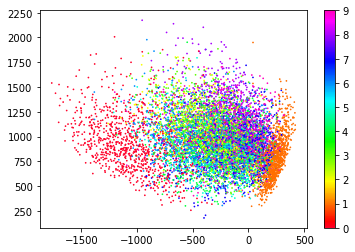

In [ ]:
def plot_lowDimRep(batch_AE_func):
  low_dim_reps = batch_AE_func(params, train_images, True)
  #my_cmap = colors.ListedColormap(['k','b','y','g','r'])

  plt.scatter(low_dim_reps[:,0],low_dim_reps[:,1],s=0.5,c=train_labels,cmap='gist_rainbow')

  plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9])

plot_lowDimRep(batch_LinAE)

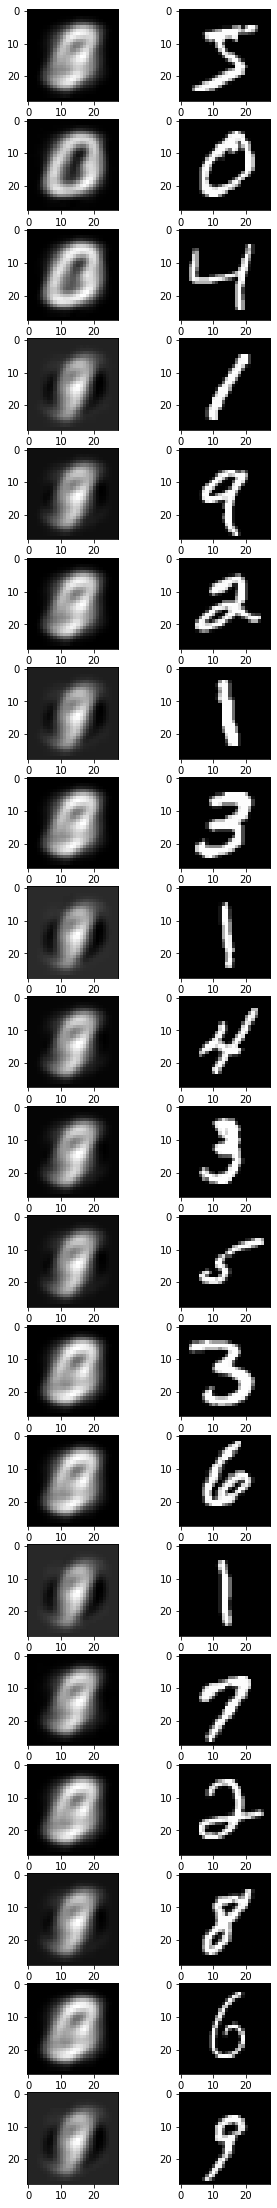

In [ ]:
def plot_AE_reconstructions(AE_func,n_show = 20):
  figure = plt.figure(figsize=(5, 2*n_show))
  for ix in range(n_show):

    img = AE_func(params,train_images[ix],False).reshape((28,28))
    plt.subplot(n_show, 2, 2*ix+1)
    #plt.subplots_adjust(hspace =.5, wspace=.5)
    plt.imshow(img, cmap='gray')
    #plt.show()

    img = train_images[ix].reshape((28,28))
    plt.subplot(n_show, 2, 2*ix+2)
    #plt.subplots_adjust(hspace =.5, wspace=.5)
    plt.imshow(img, cmap='gray')
    #plt.show()

plot_AE_reconstructions(LinAE)


# Non-linear AE

In [ ]:
layer_sizes = [784, 1000, 2, 1000, 784]
params = init_network_params(layer_sizes, key)

# rectified linear unit activation function
def relu(x):
  return jnp.maximum(0, x) # compute the element-wise function

def NonLinAE(params, image, low_dim_rep = False):
    # per-example predictions
    x = image
    # first layer is feedforward
    w, b = params[0]
    x = (jnp.dot(w, x) + b)
    x_relu = relu(x)

    low_dim_layer = 2
    for w, b in params[1:low_dim_layer]:
        #skip pre activations
        x = (jnp.dot(w, x_relu) + b)
        x_relu = relu(x)

    if low_dim_rep == True:
      return x

    x_relu = x

    for w, b in params[low_dim_layer:-1]:
        #skip pre activations
        x = (jnp.dot(w, x_relu) + b)
        x_relu = relu(x)

    final_w, final_b = params[-1]
    return (jnp.dot(final_w,  x_relu) + final_b)
    #logits = logits - jnp.max(logits)
    #return logits - jnp.log(jnp.sum(jnp.exp(logits)))

print("NonLinAE on a single examples")
print(LinAE(params, train_images[0],False).shape)

print("LowDim NonLinAE on a single examples")
print(LinAE(params, train_images[0],True).shape)


batch_NonLinAE = jax.vmap(NonLinAE,(None,0,None))

print("batch_LinAE on all examples")
print(batch_NonLinAE(params, train_images,False).shape)

def NonLinAE_loss(params, images, labels):
  return jnp.mean( (batch_NonLinAE(params,images,False) - images)**2 )

print(NonLinAE_loss(params,train_images,train_labels))


NonLinAE on a single examples
(784,)
LowDim NonLinAE on a single examples
(1000,)
batch_LinAE on all examples
(10000, 784)
7314.5605


In [ ]:
training_loop(NonLinAE_loss,num_epochs=50,step_size = 0.00002)

---Epoch 1 in 2.44 sec---
  Train loss: 2993.5967
  Test  loss: 3020.6660
---Epoch 2 in 2.40 sec---
  Train loss: 2990.5229
  Test  loss: 3017.9536
---Epoch 3 in 2.44 sec---
  Train loss: 2987.6138
  Test  loss: 3015.4666
---Epoch 4 in 2.37 sec---
  Train loss: 2984.8154
  Test  loss: 3013.1514
---Epoch 5 in 2.42 sec---
  Train loss: 2982.0718
  Test  loss: 3010.7556
---Epoch 6 in 2.42 sec---
  Train loss: 2979.5432
  Test  loss: 3008.6655
---Epoch 7 in 2.41 sec---
  Train loss: 2976.8171
  Test  loss: 3006.3813
---Epoch 8 in 2.46 sec---
  Train loss: 2974.2781
  Test  loss: 3004.2163
---Epoch 9 in 2.40 sec---
  Train loss: 2971.7437
  Test  loss: 3002.1580
---Epoch 10 in 2.43 sec---
  Train loss: 2969.3760
  Test  loss: 3000.4246
---Epoch 11 in 2.55 sec---
  Train loss: 2966.9863
  Test  loss: 2998.4204
---Epoch 12 in 3.08 sec---
  Train loss: 2964.9036
  Test  loss: 2996.8684
---Epoch 13 in 2.45 sec---
  Train loss: 2963.0581
  Test  loss: 2995.4641
---Epoch 14 in 2.44 sec---
  Train

[{'epoch': 1, 'train_loss': 2993.5966796875, 'test_loss': 3020.666015625},
 {'epoch': 2, 'train_loss': 2990.52294921875, 'test_loss': 3017.95361328125},
 {'epoch': 3, 'train_loss': 2987.61376953125, 'test_loss': 3015.466552734375},
 {'epoch': 4, 'train_loss': 2984.8154296875, 'test_loss': 3013.1513671875},
 {'epoch': 5, 'train_loss': 2982.07177734375, 'test_loss': 3010.755615234375},
 {'epoch': 6, 'train_loss': 2979.543212890625, 'test_loss': 3008.66552734375},
 {'epoch': 7, 'train_loss': 2976.817138671875, 'test_loss': 3006.38134765625},
 {'epoch': 8, 'train_loss': 2974.278076171875, 'test_loss': 3004.21630859375},
 {'epoch': 9, 'train_loss': 2971.74365234375, 'test_loss': 3002.157958984375},
 {'epoch': 10, 'train_loss': 2969.3759765625, 'test_loss': 3000.424560546875},
 {'epoch': 11, 'train_loss': 2966.986328125, 'test_loss': 2998.42041015625},
 {'epoch': 12,
  'train_loss': 2964.903564453125,
  'test_loss': 2996.868408203125},
 {'epoch': 13, 'train_loss': 2963.05810546875, 'test_los

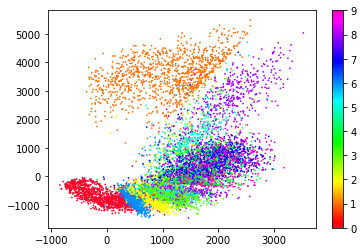

In [ ]:
plot_lowDimRep(batch_NonLinAE)

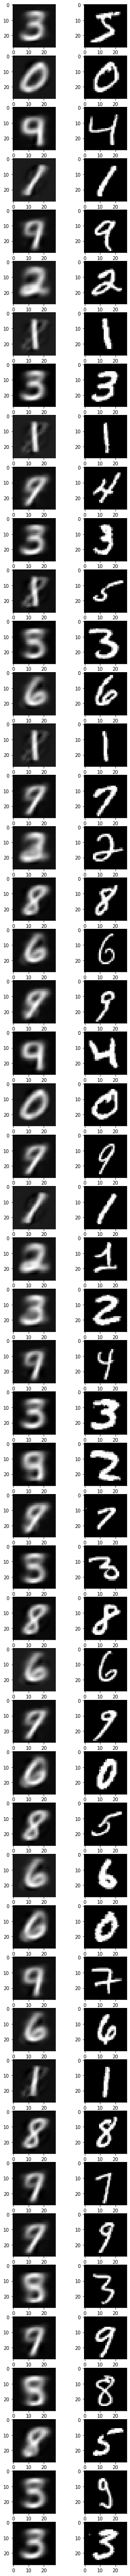

In [ ]:
plot_AE_reconstructions(NonLinAE,n_show=50)